In [1]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (0.24.2)
Requirement not upgraded as not directly required: numpy>=1.12.0 in /opt/conda/lib/python3.6/site-packages (from pandas) (1.16.3)
Requirement not upgraded as not directly required: pytz>=2011k in /opt/conda/lib/python3.6/site-packages (from pandas) (2019.1)
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /opt/conda/lib/python3.6/site-packages (from pandas) (2.8.0)
Requirement not upgraded as not directly required: six>=1.5 in /opt/conda/lib/python3.6/site-packages (from python-dateutil>=2.5.0->pandas) (1.11.0)
pyspark 2.3.2 requires py4j==0.10.7, which is not installed.
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
### Reading JSON files

# Declare paths for import
path_r = 'review.json'
path_u = 'user.json'
path_b = 'business.json'

# Import JSON files into Spark DataFrames
reviews_raw = spark.read.json(path_r)
user = spark.read.json(path_u)
business = spark.read.json(path_b)

In [3]:
# Take a look at the first 5 rows
reviews_raw.show(5)

# How many reviews in the dataset?
# Count rows and print
print('Number of reviews:', reviews_raw.count())

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|ujmEBvifdJM6h6RLv...|   0|2013-05-07 04:34:36|    1|Q1sbwvVQXV2734tPg...|  1.0|Total bill for th...|     6|hG7b0MtEbXx5QzbzE...|
|NZnhc2sEQy3RmzKTZ...|   0|2017-01-14 21:30:33|    0|GJXCdrto3ASJOqKeV...|  5.0|I *adore* Travis ...|     0|yXQM5uF2jS6es16SJ...|
|WTqjgwHlXbSFevF32...|   0|2016-11-09 20:09:03|    0|2TzJjDVDEuAW6MR5V...|  5.0|I have to say tha...|     3|n6-Gk65cPZL6Uz8qR...|
|ikCg8xy5JIg_NGPx-...|   0|2018-01-09 20:56:38|    0|yi0R0Ugj_xUx_Nek0...|  5.0|Went in for a lun...|     0|dacAIZ6fTM6mqwW5u...|
|b1b1eb3uo-w561D0Z...|   0|2018-01-30 23:07:38|    0|11a8sVPMUFtaC7_AB...|  1.0|Today was 

In [4]:
# Visualize the inferred schema of our DataFrame
reviews_raw.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [5]:
# Create temporary table for SQL querying
reviews_raw.createOrReplaceTempView("reviews")

# Reduce DataFrame to include only relevant variables
reviews = spark.sql('SELECT date, review_id, stars, text, user_id, business_id, useful FROM reviews')

# Update temporary table for SQL querying
reviews.createOrReplaceTempView("reviews")

reviews.show(5) # Look at first 5 entries

+-------------------+--------------------+-----+--------------------+--------------------+--------------------+------+
|               date|           review_id|stars|                text|             user_id|         business_id|useful|
+-------------------+--------------------+-----+--------------------+--------------------+--------------------+------+
|2013-05-07 04:34:36|Q1sbwvVQXV2734tPg...|  1.0|Total bill for th...|hG7b0MtEbXx5QzbzE...|ujmEBvifdJM6h6RLv...|     6|
|2017-01-14 21:30:33|GJXCdrto3ASJOqKeV...|  5.0|I *adore* Travis ...|yXQM5uF2jS6es16SJ...|NZnhc2sEQy3RmzKTZ...|     0|
|2016-11-09 20:09:03|2TzJjDVDEuAW6MR5V...|  5.0|I have to say tha...|n6-Gk65cPZL6Uz8qR...|WTqjgwHlXbSFevF32...|     3|
|2018-01-09 20:56:38|yi0R0Ugj_xUx_Nek0...|  5.0|Went in for a lun...|dacAIZ6fTM6mqwW5u...|ikCg8xy5JIg_NGPx-...|     0|
|2018-01-30 23:07:38|11a8sVPMUFtaC7_AB...|  1.0|Today was my seco...|ssoyf2_x0EQMed6fg...|b1b1eb3uo-w561D0Z...|     7|
+-------------------+--------------------+-----+

In [6]:
# Number of reviews (count of rows)
spark.sql('SELECT COUNT(*) AS review_count FROM reviews').show()

+------------+
|review_count|
+------------+
|     6685900|
+------------+



In [7]:
# No. of unique businesses
spark.sql('\
    SELECT COUNT(DISTINCT business_id) AS business_count \
    FROM reviews').show()

# No. of unique reviewers
spark.sql('\
    SELECT COUNT(DISTINCT user_id) AS user_count \
    FROM reviews').show()

+--------------+
|business_count|
+--------------+
|        192606|
+--------------+

+----------+
|user_count|
+----------+
|   1637138|
+----------+



In [8]:
# Descriptive statistics using DataFrame API
reviews.describe('stars', 'useful').show()

+-------+------------------+------------------+
|summary|             stars|            useful|
+-------+------------------+------------------+
|  count|           6685900|           6685900|
|   mean|3.7161993149762935|1.3541339236303265|
| stddev|1.4636427449898137| 3.700192097228969|
|    min|               1.0|                -1|
|    max|               5.0|              1241|
+-------+------------------+------------------+



In [9]:
from pyspark.sql.types import * 

# Register user-defined functions (UDFs) to be used in SQL queries
spark.udf.register('udf_year', lambda x: int(x[:4]), IntegerType())
spark.udf.register('udf_month', lambda x: int(x[5:7]), IntegerType())
spark.udf.register('udf_day', lambda x: int(x[8:10]), IntegerType())
spark.udf.register('udf_hour', lambda x: int(x[11:13]), IntegerType())

# Test UDFs on first 10 rows
spark.sql('\
    SELECT date, udf_year(date) AS year, udf_month(date) AS month, udf_day(date) AS day, udf_hour(date) AS hour \
    FROM reviews').show(10)

+-------------------+----+-----+---+----+
|               date|year|month|day|hour|
+-------------------+----+-----+---+----+
|2013-05-07 04:34:36|2013|    5|  7|   4|
|2017-01-14 21:30:33|2017|    1| 14|  21|
|2016-11-09 20:09:03|2016|   11|  9|  20|
|2018-01-09 20:56:38|2018|    1|  9|  20|
|2018-01-30 23:07:38|2018|    1| 30|  23|
|2013-01-20 13:25:59|2013|    1| 20|  13|
|2016-05-07 01:21:02|2016|    5|  7|   1|
|2010-10-05 19:12:35|2010|   10|  5|  19|
|2015-01-18 14:04:18|2015|    1| 18|  14|
|2012-02-29 21:52:43|2012|    2| 29|  21|
+-------------------+----+-----+---+----+
only showing top 10 rows



In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# No. of reviews by year
reviewsByYear = \
    spark.sql('\
        SELECT udf_year(date) AS year, COUNT(*) AS review_count\
        FROM reviews \
        GROUP BY year')

# Convert Spark DataFrame to Pandas DataFrame
pdfYear = reviewsByYear.toPandas()
pdfYear # Take a look at the DataFrame

,year,review_count
0,2007,21389
1,2018,1177662
2,2015,952400
3,2006,5081
4,2013,491294
5,2014,704862
6,2004,13
7,2012,367090
8,2009,101173
9,2016,1098786


In [19]:
%matplotlib inline

# Set the DF's index to year and sort DF by year
pdfYear = pdfYear.set_index('year').sort_values(by = 'year')

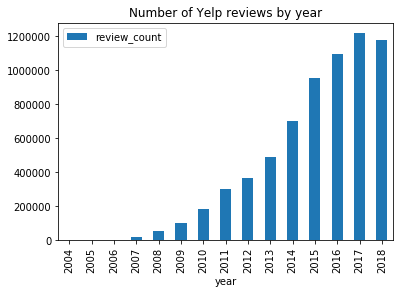

In [22]:
# Plot as bar plot
pdfYear.plot.bar(title = 'Number of Yelp reviews by year')

In [23]:
%matplotlib inline
 
# No. of reviews by month
reviewsByMonth = \
    spark.sql('\
        SELECT udf_month(date) AS month, COUNT(*) AS review_count\
        FROM reviews \
        GROUP BY month')

# Convert PySpark DataFrame to Pandas DataFrame
pdf2 = reviewsByMonth.toPandas()

# Set the index and sort by month
pdf2 = pdf2.set_index('month').sort_values(by = 'month')

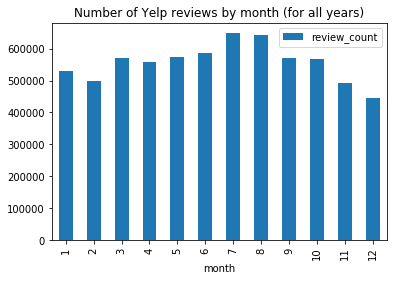

In [24]:
# Plot as bar plot
pdf2.plot.bar(title = 'Number of Yelp reviews by month (for all years)')

In [25]:
# Find all reviews that include the word "terrible"
reviewsTerrible = \
    spark.sql('\
        SELECT text, stars, useful \
        FROM reviews \
        WHERE text LIKE "%terrible%"')

reviewsTerrible.show(5)

+--------------------+-----+------+
|                text|stars|useful|
+--------------------+-----+------+
|Met a friend for ...|  1.0|     6|
|((( LADIES BEWARE...|  1.0|     1|
|Hey....i just wan...|  5.0|     0|
|I just had a terr...|  1.0|     0|
|I hope that every...|  1.0|     5|
+--------------------+-----+------+
only showing top 5 rows



In [26]:
# Create temporary tables for SQL querying
user.createOrReplaceTempView("user")
business.createOrReplaceTempView("business")

# Inferred schema of the User DataFrame
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [27]:
# Inferred schema of the Business DataFrame
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [29]:
# Usefulness of review vs. Time since joined Yelp
usefulTime = \
    spark.sql('\
        SELECT reviews.date, user.name, reviews.useful, user.yelping_since \
        FROM reviews JOIN user \
            ON reviews.user_id = user.user_id')

usefulTime.show(5)

+-------------------+-------------+------+-------------------+
|               date|         name|useful|      yelping_since|
+-------------------+-------------+------+-------------------+
|2015-08-18 19:11:04|        Scott|     3|2015-08-18 19:10:59|
|2015-08-18 19:22:17|        Scott|     0|2015-08-18 19:10:59|
|2014-03-21 17:09:59|         cubs|     0|2009-05-15 19:50:34|
|2012-07-06 03:43:34|Fairmount Jil|     1|2007-12-26 17:32:44|
|2014-09-19 01:12:10|       Nickie|     1|2009-08-07 13:42:19|
+-------------------+-------------+------+-------------------+
only showing top 5 rows



In [30]:
from pyspark.sql.types import * 
from pyspark.sql import functions as F

# Create function that calculates time difference (in days)
daysDiff = ((F.unix_timestamp('date') - F.unix_timestamp('yelping_since'))
               / (60*60*24)) # Divide by number of seconds in a day

# Adjust function to round results to 4 decimal places
daysDiff = F.round(daysDiff, 4)

# Add column to our DataFrame
usefulTime = usefulTime.withColumn("yelping_duration", daysDiff)

usefulTime.show(5)

+-------------------+-------------+------+-------------------+----------------+
|               date|         name|useful|      yelping_since|yelping_duration|
+-------------------+-------------+------+-------------------+----------------+
|2015-08-18 19:22:17|        Scott|     0|2015-08-18 19:10:59|          0.0078|
|2015-08-18 19:11:04|        Scott|     3|2015-08-18 19:10:59|          1.0E-4|
|2014-03-21 17:09:59|         cubs|     0|2009-05-15 19:50:34|       1770.8885|
|2012-07-06 03:43:34|Fairmount Jil|     1|2007-12-26 17:32:44|       1653.4242|
|2014-09-19 01:12:10|       Nickie|     1|2009-08-07 13:42:19|       1868.4791|
+-------------------+-------------+------+-------------------+----------------+
only showing top 5 rows



In [31]:
# Register UDF to count number of categories
spark.udf.register('listLength', lambda x: len(x), IntegerType())

<function __main__.<lambda>(x)>

In [34]:
# Stars relative to average vs. # of categories vs. longitude
threeJoin = \
    spark.sql('\
        SELECT ROUND(reviews.stars/user.average_stars, 2) AS stars_relative, business.longitude, \
                listLength(business.categories) AS num_categories \
        FROM user \
            JOIN reviews \
                ON user.user_id = reviews.user_id \
            JOIN business \
                ON reviews.business_id = business.business_id')

threeJoin.show(5)

+--------------+--------------+--------------+
|stars_relative|     longitude|num_categories|
+--------------+--------------+--------------+
|           0.5|  -112.0573695|            37|
|           2.0|   -111.936342|            78|
|          1.27|    -80.722003|            35|
|           1.6|-80.1499910855|            70|
|           1.0|    -89.395948|            65|
+--------------+--------------+--------------+
only showing top 5 rows



In [33]:
# Joining all three Yelp datasets in a lengthy query
threeJoinSD = \
    spark.sql("\
        SELECT business.name, business.city, ROUND(reviews.stars/user.average_stars, 2) AS stars_relative, \
                listLength(business.categories) AS num_categories, reviews.date \
        FROM user \
            JOIN reviews \
                ON user.user_id = reviews.user_id \
            JOIN business \
                ON reviews.business_id = business.business_id \
        WHERE business.city = 'San Diego' AND reviews.date LIKE '2015-01%'")

threeJoinSD.show(5)

+------------------+---------+--------------+--------------+-------------------+
|              name|     city|stars_relative|num_categories|               date|
+------------------+---------+--------------+--------------+-------------------+
|Brooks Photography|San Diego|          0.24|            80|2015-01-29 05:45:49|
|Brooks Photography|San Diego|          0.26|            80|2015-01-14 14:52:34|
|Brooks Photography|San Diego|          0.29|            80|2015-01-12 02:53:40|
|Brooks Photography|San Diego|           1.0|            80|2015-01-10 05:48:14|
|Brooks Photography|San Diego|          0.53|            80|2015-01-14 03:25:57|
+------------------+---------+--------------+--------------+-------------------+
only showing top 5 rows



In [35]:
# How many partitions is the DataFrame divided into?
reviews.rdd.getNumPartitions()

40

In [36]:
# Repartitioning a DataFrame
reviews.repartition(100).rdd.getNumPartitions()

100

In [53]:
import time
from numpy import array, mean

times1 = []
npart1 = range(60,20,-1)

for i in npart1:
    reviews = reviews.repartition(i) # Repartition the RDD
    #print("Number of partitions:", i)
    t0 = time.time() # Start clock (call it time t0)
    
    # Run query
    spark.sql('SELECT date, stars, useful FROM reviews').take(1)
    
    dt = time.time() - t0 # Measure time since t0
    #print("time: ",dt) 
    times1 = times1 + [dt] # Add time to list for plotting purposes

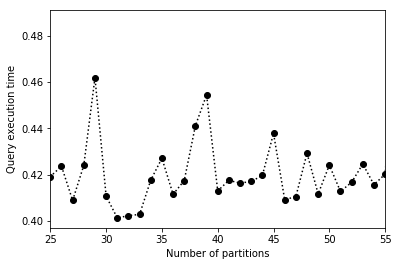

In [54]:
### Plotting the results ###

from matplotlib import pyplot as plt
%matplotlib inline

# Plot parameters
plt.plot(npart1, times1, 'ko:') # Basic parameters
plt.xlabel("Number of partitions") # x-axis label
plt.ylabel("Query execution time") # y-axis label
plt.xlim([25,55]) # x-axis limits
#plt.ylim([12,14])
plt.show() # Show

In [55]:
import time
from numpy import array

times2 = []
npart2 = range(60,20,-1)

for i in npart2:
    reviews = reviews.repartition(i) # Repartition the RDD
    #print("Number of partitions:", i)
    t0 = time.time() # Start clock (call it time t0)
    
    # Run query
    spark.sql('\
        SELECT udf_year(date) AS year, COUNT(*) AS review_count\
        FROM reviews \
        GROUP BY year').take(1)
    
    dt = time.time() - t0 # Measure time since t0
    #print("time: ",dt) 
    times2 = times2 + [dt] # Add time to list for plotting purposes

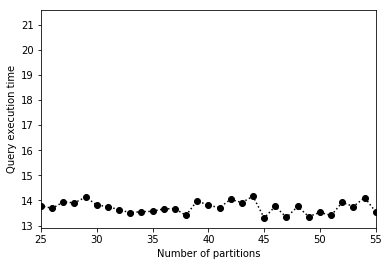

In [56]:
### Plotting the results ###

from matplotlib import pyplot as plt
%matplotlib inline

# Plot parameters
plt.plot(npart2, times2, 'ko:') 
plt.xlabel("Number of partitions") 
plt.ylabel("Query execution time") 
#plt.ylim([12,14])
plt.xlim([25,55])
plt.show()